In [44]:
### BOOK TO WORK OUT THE CODE FOR BASEBALL FIELD COMPARISON

### TAKING THE BONES FROM ETL_FOR_JSON BUT IT NEVER WORKED IN THAT BOOK

## 1. IMPORT LIBRARIES
from bs4 import BeautifulSoup
import pandas as pd
import geopandas as gpd
import os
import json
import numpy as np

import re
import time

import pyproj
from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely.ops import transform
from shapely.affinity import rotate


from geopy.distance import great_circle
import matplotlib.pyplot as plt


start_time = time.time()

## 2. SET UP PATHS
## KML path for the baseball fields
file_path = ('data/kml/College - All.kml') # file path to kml file

## 2A. SET UP NESSISARY DICTIONARIES
# Define a dictionary that maps level indicators to levels and size factors
level_dict = {
    'International': 'international',
    'Major Leagues': 'mlb', 
    'Professional': 'pro', 
    'College': 'college', 
    'High School': 'high_school',
    'Youth': 'youth',
    
}




In [45]:
## Load the KML File to evaluate
with open(file_path) as file:

    xml_data = file.read()

# Initialize soup variables for parsing file
soup = BeautifulSoup(xml_data, 'xml')
folders = soup.Document.Folder
list = soup.Document.Folder.find_all('Folder')

## Create a dataframe to hold the data parsed from xml
df = pd.DataFrame(columns=['field', 'foul', 'fop'])

failed = []

## 3. PARSE THE KML FILE
# Create an empty list to store the rows to append to the DataFrame
rows = []

# Loop through the folders and extract the data
for folder in list:
    try:
        field_name = folder.find('name').text
        foul = folder.find_all('coordinates')[0].text
        fop = folder.find_all('coordinates')[1].text

        row = {
            'field': field_name,
            'foul': foul,
            'fop': fop
        }

        rows.append(row)

    except Exception as e:
        # Add name of folder to a list of failed folders
        failed.append(folder.find('name').text)
        print(f"Error processing folder: {folder.find('name').text}. Error message: {str(e)}")

# Convert the list of rows to a DataFrame
df = pd.DataFrame(rows)

# Print a list of failed folders
print(f"Failed to process {len(failed)} folders: {', '.join(failed)}")

# Create a copy of the original DataFrame
df_cleaned = df.copy()

# Remove new line and space characters from coordinates
df_cleaned = df_cleaned.replace(r'\n','', regex=True) 
df_cleaned = df_cleaned.replace(r'\t','', regex=True) 

# Drop any duplicate rows
df_cleaned = df_cleaned.drop_duplicates(subset=['field'], keep='first')

# Drop any rows with empty fields
df_cleaned = df_cleaned[(df_cleaned != 0).all(1)]

# Define the regex patterns for each level
re_mlb = re.compile(r'mlb', re.IGNORECASE)
re_pro = re.compile(r'pro|semi[-\s]*pro', re.IGNORECASE)
re_college = re.compile(r'college', re.IGNORECASE)
re_high_school = re.compile(r'high school|hs', re.IGNORECASE)  # Include the abbreviation 'hs'
re_youth = re.compile(r'youth', re.IGNORECASE)
re_muni = re.compile(r'muni', re.IGNORECASE)
re_international = re.compile(r'international', re.IGNORECASE)

# Define a function to classify the fields based on the regex patterns
def classify_field(field_name):
    if re_mlb.search(field_name):
        return 'Major League'
    elif re_pro.search(field_name):
        return 'Professional'
    elif re_college.search(field_name):
        return 'College'
    elif re_high_school.search(field_name):
        return 'High School'
    elif re_youth.search(field_name):
        return 'Youth'
    elif re_muni.search(field_name):
        return 'State / County / Municipal'
    elif re_international.search(field_name):
        return 'International'
    else:
        return 'Unknown'

# Apply the classify_field function to the 'field' column
df_cleaned['level'] = df_cleaned['field'].apply(classify_field)

# Clean up the 'field' column by removing the level indicator and any trailing '-' characters
level_regex = r'\s*(%s)\s*' % '|'.join(re.escape(level) for level in level_dict.values())
df_cleaned['field'] = df_cleaned['field'].str.replace(level_regex, '', regex=True, flags=re.IGNORECASE)
df_cleaned['field'] = df_cleaned['field'].str.replace(r'-\s*$', '', regex=True)

# Rename field column to park_name to avoid confusion down the line
df_cleaned = df_cleaned.rename(columns={'field': 'park_name'})

##### Clean up polygon data and create a new home_plate column
def parse_coordinates(coord_string):
    coords = coord_string.split()
    parsed_coords = [tuple(map(float, coord.split(',')[:2])) for coord in coords]
    return parsed_coords

# Create a new column for the home_plate location using the first set of coordinates in the 'fop' column
df_cleaned['home_plate'] = df_cleaned['fop'].apply(lambda x: parse_coordinates(x)[0])
# Apply the parse_coordinates function to the 'foul' and 'fop' columns
df_cleaned['foul'] = df_cleaned['foul'].apply(parse_coordinates)
df_cleaned['fop'] = df_cleaned['fop'].apply(parse_coordinates)

# 4. PROFORM GEOGRAPHIC CALCULATIONS - DISTANCE, AREA, ETC.
def calculate_area(coords):
    # Create a Polygon object from the coordinates
    polygon = Polygon(coords)

    # Calculate the centroid of the polygon
    centroid = polygon.centroid

    # Create a custom LAEA projection centered on the centroid
    custom_projection = f"+proj=laea +lat_0={centroid.y} +lon_0={centroid.x} +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"

    # Create a transformer for converting coordinates to the custom LAEA projection
    transformer = pyproj.Transformer.from_crs(
        pyproj.CRS("EPSG:4326"),  # WGS 84 (latitude and longitude)
        pyproj.CRS(custom_projection),  # Custom LAEA projection
        always_xy=True
    )

    # Define a function to transform coordinates using the transformer
    def transform_coordinates(x, y):
        return transformer.transform(x, y)

    # Convert the coordinates to the custom LAEA projection
    polygon_laea = transform(transform_coordinates, polygon)

    # Calculate the area in square meters
    area_sqm = polygon_laea.area

    # Convert the area to square feet (1 square meter = 10.764 square feet)
    area_sqft = area_sqm * 10.764

    return area_sqft



### Call Function and add to dataframe
df_cleaned['foul_area_sqft'] = df_cleaned['foul'].apply(calculate_area)
df_cleaned['fop_area_sqft'] = df_cleaned['fop'].apply(calculate_area)

## Calculate the total area of the field and the ratio of foul area to field area
df_cleaned['field_area_sqft'] = df_cleaned['foul_area_sqft'] + df_cleaned['fop_area_sqft']
## Percentage foul area
df_cleaned['foul_area_per'] = df_cleaned['foul_area_sqft'] / df_cleaned['field_area_sqft']
## Fair to Foul Ratio
df_cleaned['fair_to_foul'] = df_cleaned['fop_area_sqft'] / df_cleaned['foul_area_sqft']

# 4B. Calculate the distance from home plate to the outfield fences
def interpolate_points(start, end, length_ratio):
    start_np = np.array(start)
    end_np = np.array(end)
    return tuple(start_np + (end_np - start_np) * length_ratio)

def calculate_distances(home_plate, outfield_coords, num_points=540):
    def is_same_point(point1, point2, tolerance=1e-6):
        return abs(point1[0] - point2[0]) < tolerance and abs(point1[1] - point2[1]) < tolerance

    home_plate_lat_lon = (home_plate[1], home_plate[0])
    distances = []

    # Calculate total line length
    total_length = 0
    segments = []
    for i in range(len(outfield_coords) - 1):
        start = outfield_coords[i]
        end = outfield_coords[i + 1]
        if not is_same_point(home_plate, start) and not is_same_point(home_plate, end):
            segment_length = great_circle((start[1], start[0]), (end[1], end[0])).feet
            segments.append((start, end, segment_length))
            total_length += segment_length

    # Calculate the distance between equally spaced points
    spacing = total_length / (num_points - 1)

    # Interpolate points and calculate distances
    current_length = 0
    segment_index = 0
    for i in range(num_points):
        while segment_index < len(segments) - 1 and current_length > segments[segment_index][2]:
            current_length -= segments[segment_index][2]
            segment_index += 1

        start, end, segment_length = segments[segment_index]
        length_ratio = current_length / segment_length
        point = interpolate_points(start, end, length_ratio)
        distance = great_circle(home_plate_lat_lon, (point[1], point[0])).feet
        distances.append(distance)

        current_length += spacing

    return distances

# Calculate distances for each row
df_cleaned['distances'] = df_cleaned.apply(lambda row: calculate_distances(row['home_plate'], row['fop']), axis=1)

# Calculate max, min, and average distances for each row
df_cleaned['max_distance'] = df_cleaned['distances'].apply(max)
df_cleaned['min_distance'] = df_cleaned['distances'].apply(min)
df_cleaned['avg_distance'] = df_cleaned['distances'].apply(lambda distances: sum(distances) / len(distances))
# get the median distance
df_cleaned['median_distance'] = df_cleaned['distances'].apply(lambda distances: np.median(distances))

## Return the dataframe as df
df = df_cleaned




Failed to process 0 folders: 


In [46]:
# ## Display the dataframe so I can start working on the new functions
# print(df.info())

# print(df.columns)

# df.sample()


In [47]:
## Reverse the order of the tuples within the coordinate columns (foul, fop, home_plate)
def reverse_tuples(coords):
    return [(coord[1], coord[0]) for coord in coords]

df['foul'] = df['foul'].apply(reverse_tuples)
df['fop'] = df['fop'].apply(reverse_tuples)

# Reverse the home plate coordinates single tuple
df['home_plate'] = df['home_plate'].apply(lambda coord: (coord[1], coord[0]))



gdf = df.copy()

In [48]:
gdf.sample(5)

,park_name,foul,fop,level,home_plate,foul_area_sqft,fop_area_sqft,field_area_sqft,foul_area_per,fair_to_foul,distances,max_distance,min_distance,avg_distance,median_distance
50,Penn - Meiklejohn Stadium,"[(39.944132, -75.1941557), (39.9438647, -75.19...","[(39.944132, -75.1941557), (39.9432847, -75.19...",College,"(39.944132, -75.1941557)",17639.076941,101612.808919,119251.885860,0.147914,5.760665,"[329.78950084427044, 329.80020782954324, 329.8...",383.889786,275.058107,353.882232,355.487325
5,Georgia - Foley Field,"[(33.941021, -83.3808625), (33.9414527, -83.37...","[(33.941021, -83.3808625), (33.9402441, -83.38...",College,"(33.941021, -83.3808625)",25143.486467,101326.711898,126470.198365,0.198810,4.029939,"[318.73513890914785, 318.8996137139996, 319.06...",390.912708,318.735139,360.427757,359.150043
58,U of M,"[(42.2678568, -83.7420742), (42.2670088, -83.7...","[(42.2678568, -83.7420742), (42.2678355, -83.7...",College,"(42.2678568, -83.7420742)",19408.615773,100786.703042,120195.318816,0.161476,5.192885,"[319.05826076083855, 319.2128497580065, 319.37...",394.974989,309.464144,358.410441,366.688602
18,Cornerstone Baseball Field,"[(42.9811225, -85.5975511), (42.9819309, -85.5...","[(42.9811225, -85.5975511), (42.9814919, -85.5...",College,"(42.9811225, -85.5975511)",21202.261213,102966.625318,124168.886530,0.170753,4.856398,"[324.7534180021622, 324.8554588890298, 324.961...",400.067905,323.943203,362.630633,369.000332
37,Muskegon Community,"[(43.2455766, -86.1968985), (43.2464539, -86.1...","[(43.2455766, -86.1968985), (43.2455718, -86.1...",College,"(43.2455766, -86.1968985)",37597.541710,102932.336995,140529.878705,0.267541,2.737741,"[331.8059622960268, 332.2721469663958, 332.741...",392.717958,319.971764,362.173661,366.889107


In [49]:
# Create a geometry column from the 'fop' column so It can be used as a geodataframe
gdf['geometry'] = gdf['fop'].apply(lambda coords: Polygon(coords))

In [50]:
### caculate the angles between all of the vertices in the fop column
def calculate_angles(coords):
    angles = []
    for i in range(len(coords)):
        # Get the previous and next coordinates
        previous_coord = coords[i - 1]
        next_coord = coords[(i + 1) % len(coords)]

        # Calculate the angle
        angle = calculate_angle(previous_coord, coords[i], next_coord)
        angles.append(angle)

    return angles

def calculate_angle(previous_coord, coord, next_coord):
    # Calculate the vectors between the coordinates
    previous_vector = np.array(previous_coord) - np.array(coord)
    next_vector = np.array(next_coord) - np.array(coord)

    # Calculate the angle between the vectors
    angle = np.math.atan2(np.linalg.det([previous_vector, next_vector]), np.dot(previous_vector, next_vector))
    angle = np.degrees(angle)

    # Make sure the angle is between 0 and 360
    if angle < 0:
        angle += 360

    return angle

<AxesSubplot:>

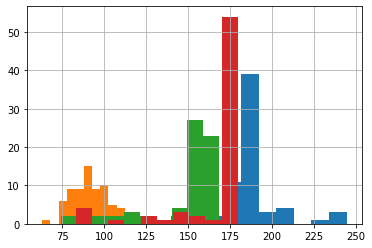

In [51]:
## Run the function
gdf['angles'] = gdf['fop'].apply(calculate_angles)
# gdf['angles'].sample()

## describe the angles column
gdf['angles'].describe()

## Create a column for the max angle
gdf['max_angle'] = gdf['angles'].apply(max)

## Create a column for the min angle
# Min angle cannot be 0
gdf['min_angle'] = gdf['angles'].apply(lambda angles: min(angle for angle in angles if angle > 0))



## Create a column for the average angle
gdf['avg_angle'] = gdf['angles'].apply(lambda angles: sum(angles) / len(angles))

## Create a column for the median angle
gdf['median_angle'] = gdf['angles'].apply(lambda angles: np.median(angles))


### Display a Summary of the angle columns
gdf[['max_angle', 'min_angle', 'avg_angle', 'median_angle']].describe()

## Display a histograms

gdf['max_angle'].hist()
gdf['min_angle'].hist()
gdf['avg_angle'].hist()
gdf['median_angle'].hist()





In [52]:
# gdf.columns

# ## print two values from the geometry column
# print(gdf['geometry'][0])
# print(gdf['geometry'][1])

In [53]:
### FUNCTIONS TO COMPARE THE FIELD DIMENSIONS TO EAACH OTHER
from ast import literal_eval
from shapely import affinity
from math import atan2


# Function to calculate shape complexity
def calculate_shape_complexity(polygon):
    hull = polygon.convex_hull
    return 1 - polygon.area / hull.area

# Function to calculate elongation
def calculate_elongation(polygon):
    return 4 * np.pi * polygon.area / (polygon.length ** 2)

# Function to calculate orientation
def calculate_orientation(polygon):
    # Create a bounding rectangle and rotate it to align with the x-axis
    rect = polygon.minimum_rotated_rectangle
    x, y = rect.exterior.coords.xy

    # find the orientation of the rectangle
    edges = np.array([np.diff(x), np.diff(y)]).T
    edge_lengths = np.sqrt(np.sum(edges**2, axis=1))
    longest_edge_index = np.argmax(edge_lengths)
    longest_edge = edges[longest_edge_index]
    
    # angle of the longest edge with respect to the x-axis
    angle = atan2(longest_edge[1], longest_edge[0])

    # rotate the polygon by the angle in degrees
    rotated_rect = affinity.rotate(rect, -angle, origin='centroid', use_radians=True)

    # Find the difference in x coordinates
    x_diff = rotated_rect.bounds[2] - rotated_rect.bounds[0]

    # Find the difference in y coordinates
    y_diff = rotated_rect.bounds[3] - rotated_rect.bounds[1]

    # Calculate orientation angle in degrees
    return np.degrees(np.arctan2(y_diff, x_diff))



In [54]:
## ORIGINAL FUNCTION
# def calculate_shape_complexity(fence_polygon):
#     # Calculate the area of the fence
#     fence_area = fence_polygon.area

#     # Calculate the circumference of a circle with the same area
#     circle_circumference = 2 * pi * (fence_area / pi) ** 0.5

#     # Calculate the complexity as the ratio of the actual fence length to the circle circumference
#     complexity = fence_polygon.length / circle_circumference

#     return complexity

In [55]:

# Calculate shape complexity, elongation, and orientation
# Apply the functions to the GeoDataFrame
gdf['shape_complexity'] = gdf['geometry'].apply(calculate_shape_complexity)
gdf['elongation'] = gdf['geometry'].apply(calculate_elongation)
gdf['orientation'] = gdf['geometry'].apply(calculate_orientation)


In [56]:
# # Describe the shape complexity, elongation, and orientation and show the results
# print(gdf['shape_complexity'].describe())
# print(gdf['elongation'].describe())
# print(gdf['orientation'].describe())

# Display the GeoDataFrame
gdf.sample()

,park_name,foul,fop,level,home_plate,foul_area_sqft,fop_area_sqft,field_area_sqft,foul_area_per,fair_to_foul,...,median_distance,geometry,angles,max_angle,min_angle,avg_angle,median_angle,shape_complexity,elongation,orientation
3,Louisville - Jim Patterson Stadium,"[(38.2054931, -85.7628209), (38.2063788, -85.7...","[(38.2054931, -85.7628209), (38.2052912, -85.7...",College,"(38.2054931, -85.7628209)",26607.776031,106415.681655,133023.457686,0.200023,3.99942,...,376.363052,"POLYGON ((38.2054931 -85.7628209, 38.2052912 -...","[0.0, 107.62790154331809, 137.26733914226804, ...",154.21722,101.21433,90.817412,107.627902,0.0,0.833116,37.509402


# Description of new calculations

shape_complexity: This metric represents how complex the shape of the baseball field is compared to its convex hull. A convex hull is the smallest convex polygon that encloses all the points of the shape. The measure is calculated as 1 minus the ratio of the area of the polygon to the area of its convex hull. If the value is close to 0, it means that the shape is similar to its convex hull, i.e., it's fairly regular or "simple". If the value is larger, it means the shape is more complex or "irregular", compared to a convex polygon. The values can range between 0 and 1. In your dataset, the maximum value is ~0.74, which means there are some fairly complex shapes in the set.

elongation: This measure is based on how elongated the shape of the baseball field is. It is calculated as the ratio of the area of the polygon to the square of its perimeter, times 4π. If the shape is perfectly circular, the elongation will be 1. If the shape is more elongated or irregular, the value will be less than 1. In your dataset, the values range between ~0.12 and ~0.87, which means there are a variety of shapes, from somewhat circular to very elongated.

orientation: This metric represents the orientation angle of the shape's minimum rotated rectangle. The minimum rotated rectangle is the smallest rectangle that can enclose the shape, and can be oriented in any direction. The angle is calculated with respect to the x-axis. The values range between -90 to 90 degrees, where 0 means aligned with the x-axis. In your dataset, the values range between ~29.25 and ~44.82 degrees, which means that the minimum bounding rectangles of the baseball fields have a variety of different orientations, all within this range.

Please note that these are geometric measures and the actual interpretation can depend on the context. For instance, in the case of baseball fields, the elongation might give you an idea of whether the field is more circular or elongated (which could impact how the game is played), the shape complexity might hint at how "standard" or "irregular" the field is, and the orientation might tell you how the field is oriented geographically (which could impact factors like sun exposure).

In [57]:
#### Get a subset of fields and create the plots of fence distance witht he name of the field and the new calculated values

## will pull the graphing code from NCAA Book

In [58]:

df = gdf 

### Get sample of 50 fields
# df = gdf.sample(50)


## create the min max and mean fence distance rows
# Transpose the dataframe to get the 
transposed_df = pd.DataFrame(df['distances'].to_list()).transpose()

# Calculate min, max, mean, median, Q1 and Q3 for each row
min_fence_distances = transposed_df.min(axis=1)
max_fence_distances = transposed_df.max(axis=1)
mean_fence_distances = transposed_df.mean(axis=1)
median_fence_distances = transposed_df.median(axis=1)
## create profiles for standard deviation
std_fence_distances = transposed_df.std(axis=1)
first_fence_distances = mean_fence_distances + std_fence_distances
third_fence_distances = mean_fence_distances - std_fence_distances

# Create a new DataFrame to store these values
new_df = pd.DataFrame({
    'park_name': ['Min', 'Max', 'Mean', 'Median', 'Q1', 'Q3'],
    'distances': [
        min_fence_distances.tolist(), 
        max_fence_distances.tolist(),
        mean_fence_distances.tolist(),
        median_fence_distances.tolist(), # Add a comma here
        first_fence_distances.tolist(),
        third_fence_distances.tolist()
    ]
})

# For all other columns in the original DataFrame, add a column of NaN values in the new DataFrame
for column in df.columns:
    if column not in new_df.columns:
        new_df[column] = np.nan

# Concatenate the new DataFrame with the original one
df = pd.concat([df, new_df], ignore_index=True)

In [59]:
df.describe()

# df.tail()
# df.head()

,foul_area_sqft,fop_area_sqft,field_area_sqft,foul_area_per,fair_to_foul,max_distance,min_distance,avg_distance,median_distance,max_angle,min_angle,avg_angle,median_angle,shape_complexity,elongation,orientation
count,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,6.800000e+01,68.000000,68.000000
mean,27488.894949,104592.108770,132081.003719,0.206681,3.992943,399.986609,320.806891,365.054693,366.858132,186.500034,90.688820,146.714524,165.787978,1.884348e-03,0.810740,37.255607
std,6059.309579,5242.918092,8522.892260,0.036102,0.927110,13.444064,23.151258,8.806064,11.267230,18.206769,10.226587,23.151165,24.328608,3.341920e-03,0.022583,2.436877
min,14270.283971,88018.470578,114233.608264,0.118728,2.440949,363.127555,160.813286,337.915960,333.254484,139.644500,62.883495,74.309010,82.889658,-2.220446e-16,0.742654,33.212516
25%,22860.875258,102339.292314,126149.177391,0.178893,3.356793,392.665937,322.146681,361.523334,361.143056,181.590852,83.109493,148.204781,172.974612,2.687738e-04,0.797483,35.536027
50%,26634.781435,104744.177154,131953.963718,0.205425,3.868020,399.271484,326.408919,365.236010,366.788855,184.087277,90.629820,152.969179,175.653659,6.970925e-04,0.813207,36.730306
75%,30722.053823,107691.230866,138162.185819,0.229527,4.590228,403.625623,328.933427,370.141200,373.805591,189.338077,97.988566,160.625545,176.877687,2.405497e-03,0.827265,38.484723
max,40392.296589,126194.803373,160825.093515,0.290617,7.422625,460.659298,347.920060,395.255035,399.743101,244.540913,112.275898,168.286686,179.692111,2.213391e-02,0.853791,44.824813


In [60]:
# VERSION 1.0 - CREATE AND COMPARE TO AN IDEA FIELD (315 down the line 380 to center in an eaven arc)

## New block to generate an Ideal Field (for high school defined as 315 down the line 380 to center in an eaven arc)

import numpy as np

def generate_ideal_field(foul_pole_distance, center_field_distance, num_points=540):
    # Generate an array of angles from -45 to 45 degrees (representing the arc from one foul pole to the other)
    angles = np.linspace(-45, 45, num_points)

    # For each angle, calculate the ideal distance using the formulas provided
    ideal_distances = [foul_pole_distance if abs(angle) == 45 else center_field_distance / np.cos(np.radians(angle)) for angle in angles]

    return ideal_distances

ideal_field = generate_ideal_field(315, 380)

def compute_field_score(actual_distances, ideal_distances):
    # Calculate the absolute difference between the actual and ideal distances at each point
    differences = np.abs(np.array(actual_distances) - np.array(ideal_distances))

    # Sum up these differences to get the total deviation
    total_deviation = np.sum(differences)

    # Normalize this score to a 0-10 scale. We will use a scale factor for this normalization,
    # which you might need to adjust based on what you consider a "maximum" deviation.
    # For example, if you consider a field with an average deviation of 100 feet at each point to be the "worst" field (score 0),
    # then the scale factor would be 100 * number_of_points.
    # You will need to adjust this based on your domain knowledge and the actual data.
    scale_factor = 100 * len(actual_distances)
    score = 10 * (1 - total_deviation / scale_factor)

    # Clamp the score between 0 and 10 just in case
    score = max(0, min(10, score))

    return score




In [61]:
df['score'] = df['distances'].apply(lambda distances: compute_field_score(distances, ideal_field))


In [62]:
### Create score 2 with the fence distance to the median field
df['score2'] = df['distances'].apply(lambda distances: compute_field_score(distances, median_fence_distances))


In [63]:
# df.sort_values(by='score', ascending=False, inplace=True)

df.head(5)

,park_name,foul,fop,level,home_plate,foul_area_sqft,fop_area_sqft,field_area_sqft,foul_area_per,fair_to_foul,...,angles,max_angle,min_angle,avg_angle,median_angle,shape_complexity,elongation,orientation,score,score2
0,UCLA - Jackie Robinson Stadium,"[(34.0588533, -118.4594238), (34.0595965, -118...","[(34.0588533, -118.4594238), (34.0593816, -118...",College,"(34.0588533, -118.4594238)",26661.786840,104050.434055,130712.220895,0.203973,3.902605,...,"[0.0, 83.89847597886828, 181.21128962819233, 1...",184.051646,83.595244,161.722916,176.683233,0.000271,0.805365,41.560770,3.548743,9.773695
1,Texas Tech - Rip Griffin Park,"[(33.5889242, -101.8772094), (33.5889286, -101...","[(33.5889242, -101.8772094), (33.5880349, -101...",College,"(33.5889242, -101.8772094)",22868.123827,108964.078152,131832.201978,0.173464,4.764889,...,"[0.0, 119.21244778104777, 156.67898068410477, ...",159.586947,100.020607,109.935494,142.522355,0.000000,0.843450,39.484715,3.705228,9.398555
2,UNC - Boshamer Stadium,"[(35.9062911, -79.0430417), (35.9054884, -79.0...","[(35.9062911, -79.0430417), (35.9058311, -79.0...",College,"(35.9062911, -79.0430417)",24520.760121,103172.346379,127693.106500,0.192029,4.207551,...,"[0.0, 87.68840090962613, 185.8853806317061, 16...",189.987232,77.927103,150.908656,175.164495,0.011890,0.773605,37.292467,3.269176,9.357263
3,Louisville - Jim Patterson Stadium,"[(38.2054931, -85.7628209), (38.2063788, -85.7...","[(38.2054931, -85.7628209), (38.2052912, -85.7...",College,"(38.2054931, -85.7628209)",26607.776031,106415.681655,133023.457686,0.200023,3.999420,...,"[0.0, 107.62790154331809, 137.26733914226804, ...",154.217220,101.214330,90.817412,107.627902,0.000000,0.833116,37.509402,3.738162,9.492382
4,Ole Miss - Oxford-University Stadium,"[(34.3618888, -89.5293021), (34.3627899, -89.5...","[(34.3618888, -89.5293021), (34.3618932, -89.5...",College,"(34.3618888, -89.5293021)",23456.370660,102355.174688,125811.545348,0.186441,4.363641,...,"[0.0, 96.30325385257515, 175.04048335146635, 1...",187.778627,95.464264,162.501642,176.531318,0.000792,0.826629,39.675838,3.267733,9.602861


<AxesSubplot:>

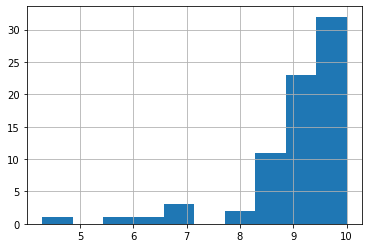

In [69]:
## Histograph of the scores (1 and 2)

# df['score'].hist()
df['score2'].hist()

In [65]:
# Set the output directory for the Outfield Fence Plots

output_dir = 'TEMP/graph/'

def plot_distances(df, row_index):
    # Get rows with 'Min', 'Max', 'Mean', 'Q1', 'Q3' in 'park_name'
    rows_to_plot = df[df['park_name'].isin(['Min', 'Max', 'Mean', 'Q1', 'Q3'])]
    
    # Get the row to be highlighted
    highlighted_row = df.loc[row_index]
    
    # Create a new figure
    fig = plt.figure(figsize=(10,8))
    fig.patch.set_facecolor('black')
    

## NOT NEEDED YET - NO COLOR COLUMN
    # # Apply the validate_color function to the color2 column
    # df['color2'] = df['color2'].apply(validate_color)
    
    
    # Loop over these rows and plot a line graph for each
    for index, row in rows_to_plot.iterrows():
        if row['park_name'] in ['Q1', 'Q3']: # If Q1 or Q3, plot thinner, dotted line
            plt.plot(row['distances'], linestyle='dotted', alpha=0.3, color='grey', label=row['park_name'])
        else:
            plt.plot(row['distances'], linestyle='dashed', alpha=0.5, label=row['park_name'])

        # Add text labels for Min, Max and Mean lines
        if row['park_name'] in ['Min', 'Max', 'Mean']:
            plt.text(len(row['distances'])-1, row['distances'][-1], row['park_name'], color='blue', va='center')

        ## Shade the standard green below the Min Line
        # Check if the current row is 'Min', if so, add shading
        if row['park_name'] == 'Min':
            plt.fill_between(range(len(row['distances'])), plt.ylim()[0], row['distances'], color='green', alpha=0.4)

        # # SHADES IN TEAM COLOR BELOW MIN LINE
        # if row['park_name'] == 'Min' and pd.notnull(highlighted_row['color1']):
        #     plt.fill_between(range(len(row['distances'])), row['distances'], color=highlighted_row['color1'], alpha=0.4)

        # Check if the current row is 'Max', if so, add shading
        if row['park_name'] == 'Max':
            plt.fill_between(range(len(row['distances'])), row['distances'], color='yellow', alpha=0.2)

        ## SHADE IN USING TEAM COLORS ABOVE MAX LINE
        if row['park_name'] == 'Max':
            plt.fill_between(range(len(row['distances'])), plt.ylim()[1], row['distances'], color='red', alpha=1.0)

            
    # Plot the highlighted row with a thicker line
    plt.plot(highlighted_row['distances'], linewidth=2, label=highlighted_row['park_name'])

    
    
    # Set the minimum and maximum values of y-axis
    plt.ylim([250, 450])

    # set the font for all the labels
    plt.rcParams['font.family'] = 'sans-serif'

    # Change y-axis labels and tick marks to be white
    plt.ylabel('Distance (feet)', color='white', size=14)
    plt.tick_params(axis='y', colors='white', size=12)



    # Hide x axis ticks
    plt.xticks([])

########################### ADDING THE FIELD Titles  ########################################

    # Add a main title and subtitle with the field name and host school
    plt.suptitle(f"{highlighted_row['park_name']}", color='black', fontsize=20, y=.25)
    plt.title(f"({highlighted_row['score']})", color='black', fontsize=16, y=.05)

    # Add text with statistics for each field
    shape_complexity = highlighted_row['shape_complexity']
    if not np.isnan(shape_complexity):
        plt.annotate(f"Complexity Rating: {(shape_complexity)}", xy=(0.05, 0.90), xycoords='axes fraction', color="black", fontsize=20, weight='bold', ha="left", va="bottom")

    elongation = highlighted_row['elongation']
    if not np.isnan(elongation):
        plt.annotate(f"Elongation: {round(elongation, 5)}", xy=(0.05, 0.75), xycoords='axes fraction', color="blue", fontsize=16,  ha="left", va="bottom")

    ### Add the two new scores to the plot
    score = highlighted_row['score']
    if not np.isnan(score):
        plt.annotate(f"Score: {round(score, 3)}", xy=(0.05, 0.60), xycoords='axes fraction', color="blue", fontsize=16,  ha="left", va="bottom")

    score2 = highlighted_row['score2']
    if not np.isnan(score2):
        plt.annotate(f"Score_to_mean: {round(10-score2, 2)}", xy=(0.05, 0.45), xycoords='axes fraction', color="blue", fontsize=16,  ha="left", va="bottom")



    # orientation = highlighted_row['orientation']
    # if not np.isnan(orientation):
    #     plt.annotate(f"Orientation: {orientation}", xy=(0.05, 0.85), xycoords='axes fraction', color="blue", fontsize=12, ha="left", va="bottom")
    # if not np.isnan(highlighted_row['orientation']):
    #     plt.annotate(f"Orientation: {orientation}", xy=(0.05, 0.70), xycoords='axes fraction', color="blue", fontsize=16, weight='bold', ha="left", va="bottom")


    
    #Games: {highlighted_row['games']} HR / G: {highlighted_row['home_runs_per_game']} ", xy=(0.05, 0.95), xycoords='axes fraction', color="white", fontsize=16, ha="left", va="bottom")


  

    # Reverse the x-axis
    plt.gca().invert_xaxis()

    # Generate the file path
    file_path = os.path.join(output_dir, f"HR SCORE {highlighted_row['score']} - {highlighted_row['park_name']}.png")
    
    # Save the figure
    plt.savefig(file_path, transparent=False)


    # Close the figure to free up memory
    plt.close()

    # Return the file path
    return file_path

# Add a new column 'file_path' to the DataFrame to store the file paths
df['file_path'] = [plot_distances(df, i) for i in df.index]





In [66]:
## stop timer and display time
end_time = time.time()

print(f"Total time: {end_time - start_time} seconds")

Total time: 15.181777715682983 seconds


In [67]:
# df.tail(15)

In [ ]:
#### 7-13-23 ### 

## New idea - seperate fields into 7 parts, down the line (2x), straight away right/left, power alleys (2x), dead center

### 540 total measurments - 7 parts = 77.14 measurments per part
# Down the line  - first and last 50 measurments
## Straight away - 100 measurements
# Power alley - 80
## straight away 100

### Ranges
dtl1 = [0,49]
left = [50,149]
l_gap = [150,229]
center = [230,329]
r_gap = [330,409]
right = [410,509]
dtl2 = [510,539]


In [ ]:
### Seperate the distances into the 7 parts
df['dtl1'] = df['distances'].apply(lambda distances: distances[dtl1[0]:dtl1[1]])
df['left'] = df['distances'].apply(lambda distances: distances[left[0]:left[1]])
df['l_gap'] = df['distances'].apply(lambda distances: distances[l_gap[0]:l_gap[1]])
df['center'] = df['distances'].apply(lambda distances: distances[center[0]:center[1]])
df['r_gap'] = df['distances'].apply(lambda distances: distances[r_gap[0]:r_gap[1]])
df['right'] = df['distances'].apply(lambda distances: distances[right[0]:right[1]])
df['dtl2'] = df['distances'].apply(lambda distances: distances[dtl2[0]:dtl2[1]])

